# Зависимость социально-экономических показателей и показателей рождаемости в России для субъектов России в период с 2013 по 2022 годы









Проект выполняют: Торова Анна, Дерюгин Тимофей, Парамонов Михаил.

Мы исследуем зависимость социально-экономических показателей и показателей рождаемости для субъектов России в период с 2013 по 2022 годы.

В качестве социально-экономических показателей мы выбрали реальную среднемесячную заработную плату для субъекта, регион, показатели безработицы, а также доля людей, находящихся за чертой бедности.

Все данные были взяты с сайта Росстата. 

In [342]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import seaborn as sns
import openpyxl
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import probplot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from statsmodels.stats.stattools import durbin_watson
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, f1_score, mean_squared_error, r2_score
import scipy.stats as sts
from sklearn import preprocessing
from wordcloud import WordCloud
import requests
from bs4 import BeautifulSoup
from sklearn.linear_model import RidgeCV, LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
import lxml
import html5lib

## Сбор и преобразование данных

Для начала подгрузим скачанные файлы в формате DataFrame и немного их подкорректируем. Nan заменим на средние значения по субъекту.

In [343]:
poverty_df = pd.read_excel('Data_for_project/bednost-2013-2022 (1).xlsx')
unemployment_df = pd.read_excel('Data_for_project/bezraboticca.xlsx')
fertility_df = pd.read_excel('Data_for_project/fertility.xlsx')
income_df = pd.read_excel('Data_for_project/zarplata.xlsx')

poverty_df.columns = ['subject'] + [int(x) for x in poverty_df.loc[1][1:].tolist()]
poverty_df.drop(labels=[0, 1], axis=0, inplace=True)
poverty_df.set_index(poverty_df['subject'], inplace=True)
poverty_df.drop(labels=['subject'], axis=1, inplace=True)
poverty_df = poverty_df.fillna(poverty_df.mean(axis=1), axis=0)

unemployment_df.set_index(unemployment_df['subject'], inplace=True)
unemployment_df.drop(labels=['subject'], axis=1, inplace=True)
unemployment_df = unemployment_df.fillna(unemployment_df.mean(axis=1), axis=0)

fertility_df.columns = ['subject'] + [int(x) for x in fertility_df.loc[0][1:].tolist()]
fertility_df.drop(labels=[0], axis=0, inplace=True)
fertility_df.set_index(fertility_df['subject'], inplace=True)
fertility_df.drop(labels=['subject'], axis=1, inplace=True)
fertility_df = fertility_df.fillna(fertility_df.mean(axis=1), axis=0)

income_df.set_index(income_df['subject'], inplace=True)
income_df.drop(labels=['subject'], axis=1, inplace=True)
income_df = income_df.fillna(income_df.mean(axis=1), axis=0)



Сведения о среднемесячных зарплатах приведены в номинальном выражении. Возьмем данные об инфляции за 2013-2022 годы и посчитаем зарплаты в реальном выражении по отношению к 2013 году. 

In [344]:
#Здесь мы воспользовались помощью Chatgpt. Запрос был задан так: спарси по ссылке (...) инфляцию с 2013 по 2022 год на питоне
response = requests.get('https://infotables.ru/statistika/79-ekonomicheskaya-statistika-rossii/1321-inflyatsiya-v-rossii-tablitsa')

soup = BeautifulSoup(response.content, 'html.parser')

table = soup.find('table')

inflation_arr = np.array([])
data_rows_raw= table.tbody.find_all('tr')

for row in data_rows_raw[1:]:
    cols=row.find_all('td')
    cols=[x.text.strip() for x in cols]
    
    year=int(cols[0])
    
    if year>=2013 and year<=2022:        
        inflation=float(cols[1].replace(',','.'))
        inflation_arr = np.append(inflation_arr, inflation)
        
inflation_arr = inflation_arr[::-1]
print(inflation_arr)

[ 6.45 11.36 12.91  5.38  2.52  4.27  3.05  4.91  8.39 10.65]


Далее считаем индекс-дефлятор, который показывает цену рубля в реальном выражении на определенный год по отношению к базовому году. Домножаем значение зарплаты каждого года на соответствующий коэффициент

In [345]:
index_deflator = np.array([1])

for i in range(9):
    index_deflator = np.append(index_deflator, index_deflator[-1]/(1+inflation_arr[i]/100))

income_df = income_df.mul(index_deflator, axis=1)

income_df

,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
subject,,,,,,,,,,
Белгородская область,20381.2,21097.980272,20099.251983,18255.004393,19532.726326,20260.923148,21129.296974,22906.242426,23190.776212,24812.928957
Брянская область,16773.9,17740.347581,16676.688370,15621.691040,16048.058374,16981.636339,17792.104319,18967.130241,19163.820579,20389.736209
Владимирская область,18379.5,19419.915453,18750.539890,17246.312242,17498.552797,19321.137931,20706.220241,20777.394413,20740.714100,21165.035883
Воронежская область,19667.8,20389.948333,19483.440232,17710.052127,17963.387906,19343.633398,20171.521289,21081.239728,21484.744780,22942.655746
Ивановская область,16529.6,17727.383748,17079.749815,14920.813988,14516.620331,16113.258036,16389.232546,17001.307049,16711.733977,17479.504155
...,...,...,...,...,...,...,...,...,...,...
Амурская область,28486.7,28071.019258,24623.865557,22729.081930,23211.685543,26172.886954,28249.839545,31084.836651,32144.297133,33721.630482
Магаданская область,52403.2,51547.393142,48853.780308,42673.483179,43241.476410,50698.291527,52976.913667,56605.011210,59952.137084,52694.172316
Сахалинская область,44705.6,46910.474401,48905.829055,51838.752495,51158.199596,52081.181240,56104.988758,60759.923722,59467.977278,59422.944875


Из текущих "сырых" таблиц теперь надо сделать одну большую. Ее колонками будут: год, регион, реальная зарплата, доля людей за чертой бедности, безработица и, конечно, рождаемость

In [346]:
#Здесь мы опять воспользовались помощью Chatgpt. Необходимо было из датафрейма 82*10 (субъектов*количество лет) 
#получить датафрейм (2*820), где одним столбцом будут год+регион, а вторым - признак (безработица или зарплата итд)
#Запросов было много, потому что он постоянно разделял год и регион и в новом датафрейме получалось много столбцов
#Итоговый запрос был таким: Есть датафрейм, столбцы - годы, индексы - субъекты РФ. Значениями таблицы является зарплата. 
#Необходимо создать датафрейм с двумя 
#колонками, в первой будет указана зарплата, во второй - вместе Субъект РФ и год

def df_remake(df, priznak):
    df_stacked = df.stack()
    df_stacked = df_stacked.reset_index()
    df_stacked = df_stacked.rename(columns={'level_0': 'subject', 'level_1': 'Year', 0: priznak})
    df_stacked['Subject and year'] = df_stacked['subject'] + ', ' + df_stacked['Year'].astype(str)
    df_result = df_stacked[[priznak, 'Subject and year']].set_index('Subject and year')

    return df_result

income_df = df_remake(income_df, 'income')
unemployment_df = df_remake(unemployment_df, 'unemployment')
fertility_df = df_remake(fertility_df, 'fertility')
poverty_df = df_remake(poverty_df, 'poverty') 

new_df = income_df.merge(unemployment_df, left_index=True, right_index=True)\
               .merge(fertility_df, left_index=True, right_index=True)\
               .merge(poverty_df, left_index=True, right_index=True)

new_df.head()


,income,unemployment,fertility,poverty
Subject and year,,,,
"Белгородская область, 2013",20381.200000,4.0,1.526,0.075979
"Белгородская область, 2014",21097.980272,4.0,1.544,0.077480
"Белгородская область, 2015",20099.251983,4.1,1.561,0.085901
"Белгородская область, 2016",18255.004393,4.0,1.547,0.081919
"Белгородская область, 2017",19532.726326,3.9,1.389,0.078786


## EDA анализ

Мы получили таблицу с 4 признаками для каждого региона и года. Теперь проведем EDA анализ

In [347]:
def EDA(df, priznak):
    print(df[priznak].describe())
    plt.hist(df[priznak], bins=30)
    plt.title(priznak)
    plt.show()
    if priznak != 'fertility':
        plt.scatter(df[priznak], df['fertility'])
        plt.xlabel(priznak)
        plt.ylabel('fertility')
        plt.show()

Рассматривая такой показатель, как реальная зарплата, можно отметить, что она имеет довольно большой разброс.Максимальный показатель з/п в три раза превышает средний. Что касается связи зарплаты и коэффициента рождаемости, наблюдается слабая зависимость.

count      816.000000
mean     24103.497118
std       9571.660934
min      13285.807763
25%      18133.001750
50%      21113.514164
75%      25957.920239
max      73749.341907
Name: income, dtype: float64


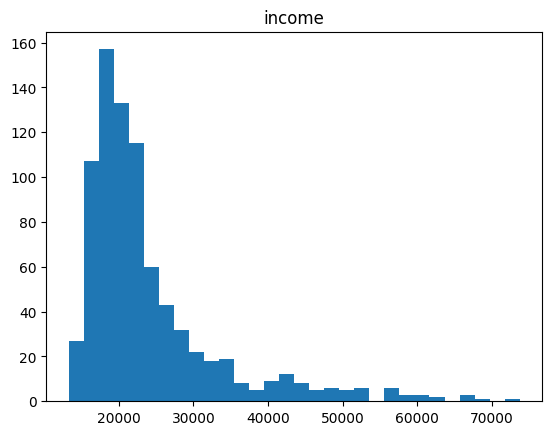

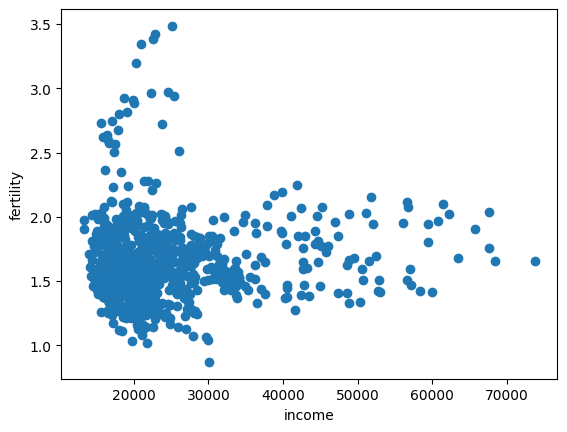

In [348]:
EDA(new_df, 'income')

Ситуация с безработицей похожа: она распределена неравномерно и имеет большой разброс. Однако, в отличие от зарплат, наблюдается более сильная положительная связь с рождаемостью

count    816.000000
mean       6.324632
std        3.981351
min        1.200000
25%        4.200000
50%        5.300000
75%        7.000000
max       43.700000
Name: unemployment, dtype: float64


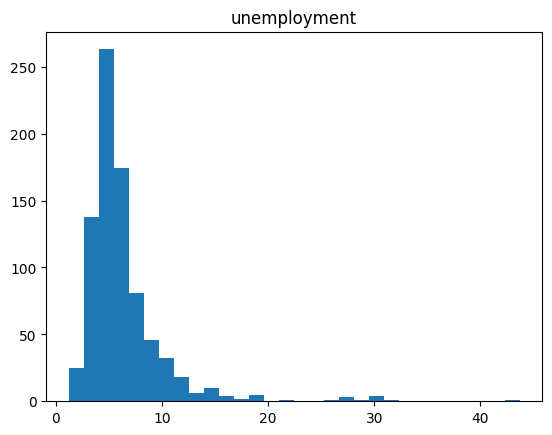

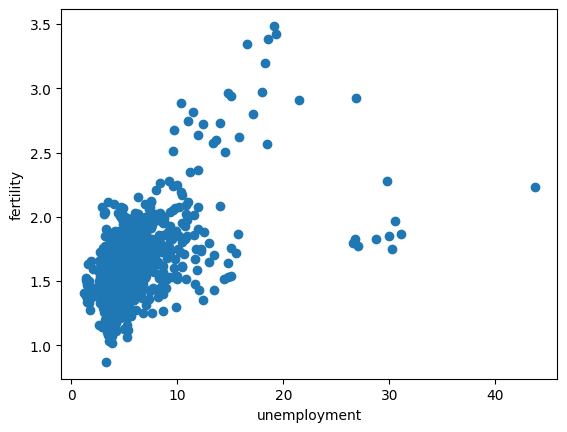

In [349]:
EDA(new_df, 'unemployment')

Бедность имеет больший разброс - гистограмма более сплюснута. Диаграмма рассеяния 
также свидетельствует о положительной взаимосвязи с рождаемостью

count    816.000000
mean       0.143952
std        0.050045
min        0.045007
25%        0.110300
50%        0.139342
75%        0.168554
max        0.359337
Name: poverty, dtype: float64


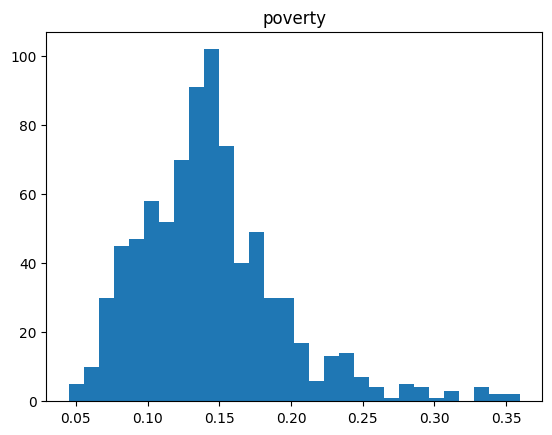

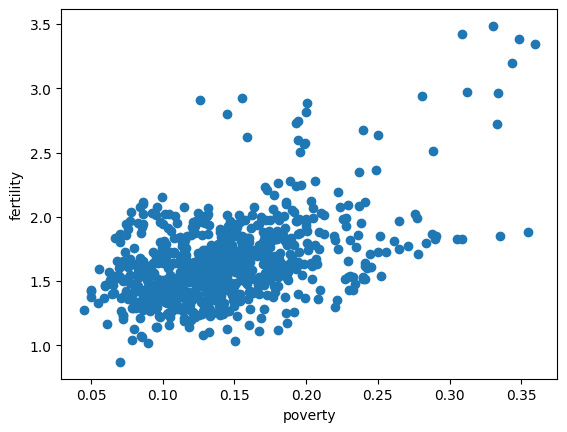

In [350]:
EDA(new_df, 'poverty')

Рождаемость имеет меньший разброс. Гистрограммы четырех показателей очень похожи - они имеют характерный пик и чем-то напоминают нормальное распереление.

count    816.000000
mean       1.648604
std        0.322276
min        0.871000
25%        1.444000
50%        1.599500
75%        1.803000
max        3.485000
Name: fertility, dtype: float64


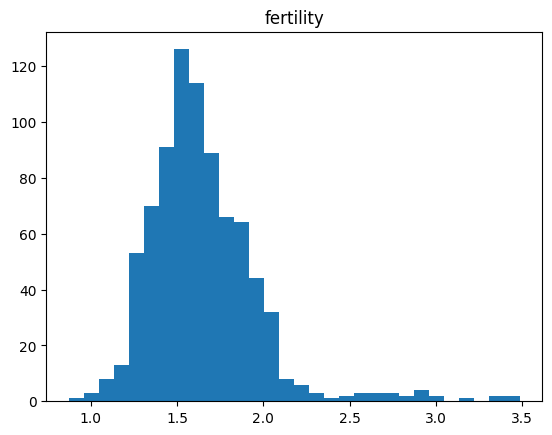

In [351]:
EDA(new_df, 'fertility')

Как видно из матрицы корреляции, между рождаемостью и бедностью, а также между рождаемостью и безработицей наблюдается значимая положительная связь.

In [352]:
new_df.corr()

,income,unemployment,fertility,poverty
income,1.000000,-0.225619,0.046948,-0.322596
unemployment,-0.225619,1.000000,0.529356,0.621222
fertility,0.046948,0.529356,1.000000,0.489319
poverty,-0.322596,0.621222,0.489319,1.000000


## Создание новых признаков

Среди выбранных факторов возможное наличие положительной связи с рождаемостью показали безработица и бедность. Связь рождаемости и реальных зарплат оказалась незначительной. 

Поэтому заработную плату как фактор мы решили заменить на темп прироста зарплаты: он будет лучше отражать экономические настроения и ожидания граждан, что играет определенную роль в рождаемости.

Территориальная составляющая, как подсказывает интуиция, очень важна в плане демографии. Однако иметь 85 вариантов у категориального признака (85 субъектов) может привести к переобучению модели. Куда логичнее будет рассмотреть, например, регионы , в которых находятся наши субъекты. Пусть это и будет нашим категориальным признаком.

#### Темп прироста реальных зарплат

Наше исследование покрывает период с 2013 по 2022 года. Для того, чтобы ввести темп прироста реальных заработных плат, нам придется пожертвовать 2013 годом как базовым.

In [353]:
new_df['income growth rate'] = 0

for i in new_df.index:

    if i[-4:] != '2013':
        try:
            s = i[:-4] + str(int(i[-4:]) - 1)
            new_df.loc[i, 'income growth rate'] = new_df.loc[i, 'income']/new_df.loc[s, 'income'] - 1
        except KeyError:
            new_df.loc[i, 'income growth rate'] = 0
    

Теперь требуется визуализировать новый признак, посчитать его корреляцию с рождаемостью

count    816.000000
mean       0.015200
std        0.072150
min       -0.390553
25%       -0.014975
50%        0.017357
75%        0.054783
max        0.918149
Name: income growth rate, dtype: float64


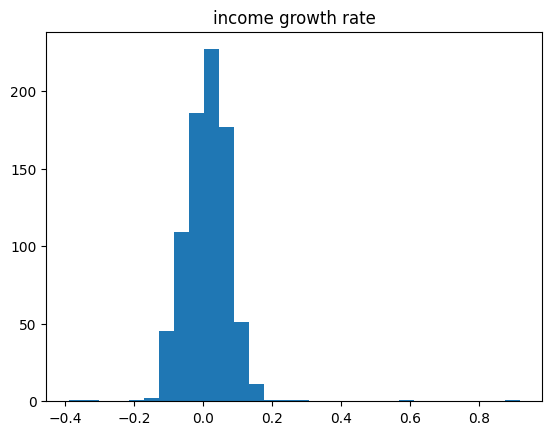

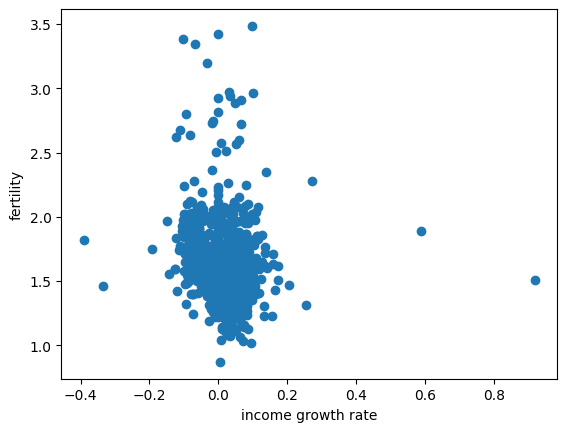

In [355]:
EDA(new_df, 'income growth rate')

Темп прироста реальных зарплат слабо рассеян. Наблюдается слабая отрицательная связь с рождаемостью.

In [356]:
new_df.corr()

,income,unemployment,fertility,poverty,income growth rate
income,1.000000,-0.225619,0.046948,-0.322596,0.091943
unemployment,-0.225619,1.000000,0.529356,0.621222,-0.053593
fertility,0.046948,0.529356,1.000000,0.489319,-0.179994
poverty,-0.322596,0.621222,0.489319,1.000000,-0.071951
income growth rate,0.091943,-0.053593,-0.179994,-0.071951,1.000000


Теперь мы построили новую матрицу корреляций. Корреляция между рождаемостью и темпом прироста зарплат отрицательная и довольно слабая, однако этот показатель в 3 раза выше, чем корреляция с зарплатами. В таком случае, темп прироста з/п будет одним из признаков в дальнейшем МО.

Оценка темпов прироста показалась нам довольно интересным показателем. Возможно, на качество исследования повлияет также оценка темпов прироста безработицы и бедности. Найдем эти показатели. Их значимость мы оценим, в первую очередь, корреляционным методом, а впоследствии посмотрим, насколько они между собой связаны. Если окажется так, что темпы прироста безработицы, бедности и реальных доходов по модулю схожи, то мы оставим только один из них. Это и ляжет в основу гипотезы, исследование которой в дальнейшем скажется на качестве модели.
Для начала запишем функцию, которая будет строить темпы приростов:

Теперь добавим новые признаки

In [357]:
new_df['poverty growth rate'] = 0

for i in new_df.index:
    if i[-4:] != '2013':
        try:
            s = i[:-4] + str(int(i[-4:]) - 1)
            new_df.loc[i, 'poverty growth rate'] = new_df.loc[i, 'poverty']/new_df.loc[s, 'poverty'] - 1
        except KeyError:
            new_df.loc[i, 'poverty growth rate'] = 0

In [358]:
new_df['unemployment growth rate'] = 0

for i in new_df.index:
    if i[-4:] != '2013':
        try:
            s = i[:-4] + str(int(i[-4:]) - 1)
            new_df.loc[i, 'unemployment growth rate'] = new_df.loc[i, 'unemployment']/new_df.loc[s, 'unemployment'] - 1
        except KeyError:
            new_df.loc[i, 'unemployment growth rate'] = 0

In [359]:
new_df.head()

,income,unemployment,fertility,poverty,income growth rate,poverty growth rate,unemployment growth rate
Subject and year,,,,,,,
"Белгородская область, 2013",20381.200000,4.0,1.526,0.075979,0.000000,0.000000,0.00000
"Белгородская область, 2014",21097.980272,4.0,1.544,0.077480,0.035169,0.019759,0.00000
"Белгородская область, 2015",20099.251983,4.1,1.561,0.085901,-0.047338,0.108677,0.02500
"Белгородская область, 2016",18255.004393,4.0,1.547,0.081919,-0.091757,-0.046353,-0.02439
"Белгородская область, 2017",19532.726326,3.9,1.389,0.078786,0.069993,-0.038247,-0.02500


In [360]:
for i in new_df.index:
    if i[-4:] == '2013':
        new_df.drop(i, inplace=True)
       
new_df.head()

,income,unemployment,fertility,poverty,income growth rate,poverty growth rate,unemployment growth rate
Subject and year,,,,,,,
"Белгородская область, 2014",21097.980272,4.0,1.544,0.077480,0.035169,0.019759,0.000000
"Белгородская область, 2015",20099.251983,4.1,1.561,0.085901,-0.047338,0.108677,0.025000
"Белгородская область, 2016",18255.004393,4.0,1.547,0.081919,-0.091757,-0.046353,-0.024390
"Белгородская область, 2017",19532.726326,3.9,1.389,0.078786,0.069993,-0.038247,-0.025000
"Белгородская область, 2018",20260.923148,4.0,1.358,0.075914,0.037281,-0.036454,0.025641


Для дальнейшего понимания хода мысли необходимо визуализировать полученные темпы прироста:

count    736.000000
mean      -0.014701
std        0.067248
min       -0.248927
25%       -0.055860
50%       -0.021600
75%        0.009342
max        0.281885
Name: poverty growth rate, dtype: float64


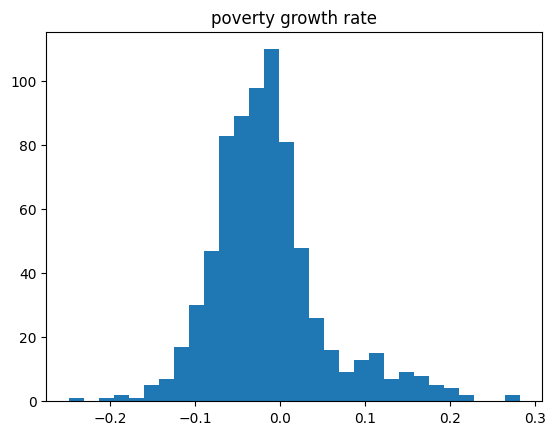

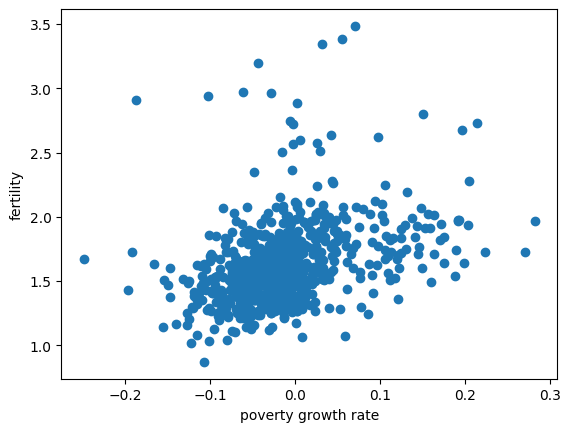

In [361]:
EDA(new_df, 'poverty growth rate')

count    736.000000
mean      -0.025364
std        0.161300
min       -0.484375
25%       -0.117865
50%       -0.036700
75%        0.033475
max        1.071429
Name: unemployment growth rate, dtype: float64


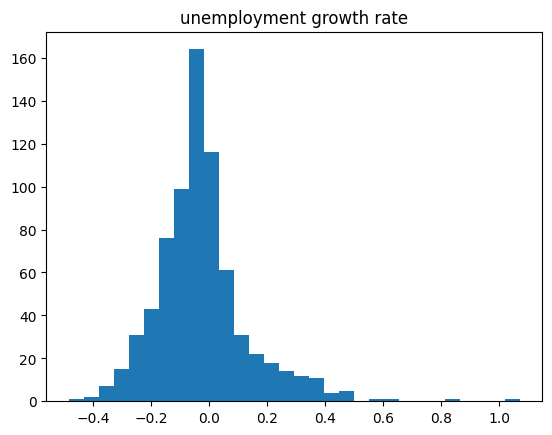

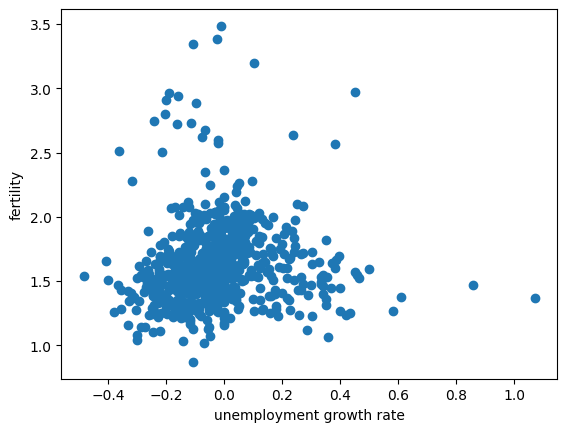

In [362]:
EDA(new_df, 'unemployment growth rate')

In [363]:
new_df.corr()

,income,unemployment,fertility,poverty,income growth rate,poverty growth rate,unemployment growth rate
income,1.000000,-0.233715,0.054320,-0.332234,0.095942,-0.153490,0.004170
unemployment,-0.233715,1.000000,0.520320,0.662736,-0.055653,0.241742,0.136967
fertility,0.054320,0.520320,1.000000,0.499630,-0.182168,0.365800,0.068161
poverty,-0.332234,0.662736,0.499630,1.000000,-0.076876,0.224894,0.052915
income growth rate,0.095942,-0.055653,-0.182168,-0.076876,1.000000,-0.283972,-0.034259
poverty growth rate,-0.153490,0.241742,0.365800,0.224894,-0.283972,1.000000,0.272041
unemployment growth rate,0.004170,0.136967,0.068161,0.052915,-0.034259,0.272041,1.000000


Согласно визуализации видно, что темпы прироста безработицы распределены схоже с распределением темпов прироста доходов. Они имеют схожие матожидания и дисперсию. Стоит проверить гипотезу о равенстве матожиданий и дисперсий этих двух показателей. Если она подтвердится, то достаточно будет рассмотреть только один из них для дальнейшего обучения модели

#### Территориальная составляющая:

In [364]:
regions_df = pd.read_csv('data_for_project/regions.csv', index_col=1)

new_df['region'] = 0

for i in new_df.index:
   
    new_df.loc[i, 'region'] = regions_df.loc[i[:-6].strip(), 'region']
    
        
new_df.head()

,income,unemployment,fertility,poverty,income growth rate,poverty growth rate,unemployment growth rate,region
Subject and year,,,,,,,,
"Белгородская область, 2014",21097.980272,4.0,1.544,0.077480,0.035169,0.019759,0.000000,Центральный
"Белгородская область, 2015",20099.251983,4.1,1.561,0.085901,-0.047338,0.108677,0.025000,Центральный
"Белгородская область, 2016",18255.004393,4.0,1.547,0.081919,-0.091757,-0.046353,-0.024390,Центральный
"Белгородская область, 2017",19532.726326,3.9,1.389,0.078786,0.069993,-0.038247,-0.025000,Центральный
"Белгородская область, 2018",20260.923148,4.0,1.358,0.075914,0.037281,-0.036454,0.025641,Центральный


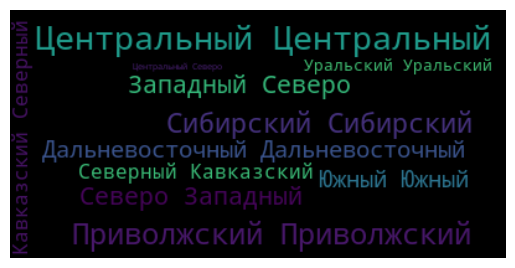

In [365]:
wordcloud = WordCloud().generate(','.join(new_df['region']))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [366]:
new_df.fillna(0, inplace=True)

### Проверка гипотез

#### Гипотеза 1

Проверим гипотезу о равенстве матожиданий темпов прироста безработицы и темпов прироста доходов

$$
H_0: \mu_{ugr} = \mu_{igr}  \\
H_1: \mu_{ugr} \neq \mu_{igr}
$$

In [367]:
sts.ttest_ind(list(new_df['unemployment growth rate']), list(new_df['income growth rate'] ))

Ttest_indResult(statistic=-6.426316452754027, pvalue=1.761960082909602e-10)

Нулевая гипотеза отвергнута на любом уровне значимости. Поэтому в модели необходимо рассмотреть оба признака.

#### Гипотеза 2

Исследуем зависимость рождаемости от региона. Для этого проверим равенство матожиданий рождаемости в двух принципиально разных округах: Дальневосточном и Центральном

$$
H_0: \mu_{f_{dv}} = \mu_{f_{ce}}  \\
H_1: \mu_{f_{dv}} \neq \mu_{f_{ce}}
$$

In [368]:
sts.ttest_ind(new_df[new_df['region'] == 'Дальневосточный']['fertility'], new_df[new_df['region'] == 'Центральный']['fertility'])

Ttest_indResult(statistic=12.302493018819208, pvalue=2.5687649887820475e-27)

Очевидно, что нулевая гипотеза также отвергается на любом уровне значимости. Значит, имеет смысл говорить о возможном наличии взаимосвязи между округом и рождаемостью

#### Гипотеза 3

Совпадают ли вероятности того, что рост темпов безработицы сопровождается ростом темпов бедности ? Интуитивно понятно,что да 

$$
H_0: p_{ugr > 0} = p_{pgr > 0}\\
H_1: p_{ugr > 0} \neq p_{pgr > 0}
$$

In [369]:
p_u = (new_df['unemployment growth rate'] > 0).mean()
p_p = (new_df['poverty growth rate'] > 0).mean()

s_u = (p_u*(1-p_u))/(new_df['unemployment growth rate'] > 0).sum()
s_p = (p_p*(1-p_p))/(new_df['poverty growth rate'] > 0).sum()

z_st = (p_u - p_p)/np.sqrt(s_u + s_p)

if abs(z_st) < sts.norm.ppf(0.95):
    print('H0 не отвергается')
else:
    print('H0 отвергается')

H0 не отвергается


Действительно, нет оснований опровергать, что рост темпов безработицы сопровождается ростом темпов бедност

## Машинное обучение

### Линейная регрессия

Начнем с базовой модели. Поскольку в модели есть как качественные, так и количественные признаки, мы будем использовать множественную регрессию. Для кодирования единственной качественной переменной $regions$ будем использовать способ фиктивных переменных dummy variables.

In [370]:
dummy = pd.get_dummies(new_df['region'])
new_df = pd.concat([new_df, dummy], axis=1)
new_df.head()

,income,unemployment,fertility,poverty,income growth rate,poverty growth rate,unemployment growth rate,region,Дальневосточный,Приволжский,Северный Кавказский,Северо-Западный,Сибирский,Уральский,Центральный,Южный
Subject and year,,,,,,,,,,,,,,,,
"Белгородская область, 2014",21097.980272,4.0,1.544,0.077480,0.035169,0.019759,0.000000,Центральный,0,0,0,0,0,0,1,0
"Белгородская область, 2015",20099.251983,4.1,1.561,0.085901,-0.047338,0.108677,0.025000,Центральный,0,0,0,0,0,0,1,0
"Белгородская область, 2016",18255.004393,4.0,1.547,0.081919,-0.091757,-0.046353,-0.024390,Центральный,0,0,0,0,0,0,1,0
"Белгородская область, 2017",19532.726326,3.9,1.389,0.078786,0.069993,-0.038247,-0.025000,Центральный,0,0,0,0,0,0,1,0
"Белгородская область, 2018",20260.923148,4.0,1.358,0.075914,0.037281,-0.036454,0.025641,Центральный,0,0,0,0,0,0,1,0


In [371]:
new_df.drop('region', axis=1, inplace=True)

In [372]:
first_model = LinearRegression()

X = new_df[['income', 'unemployment', 'poverty', 'income growth rate', 'poverty growth rate', 'unemployment growth rate', 'Дальневосточный', 'Приволжский', 'Северный Кавказский', 'Северо-Западный', 'Сибирский', 'Уральский', 'Центральный', 'Южный']]
y = new_df['fertility']

np.random.seed(1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

first_model.fit(X_train, y_train)

y_pred = first_model.predict(X_test)
y_train_pred = first_model.predict(X_train)

Теперь обратимся к метрикам качества модели и посмотрим, что можно улучшить в дальнейшем

In [373]:
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))

MAPE: 0.08983133291369581
MSE: 0.042486294243977284
R2: 0.4385293883013417


Попробуем поиграться со степенями: для 6 числовых значений признаков рассмотрим по 3 степени: квадратный корень, степень 1, квадрат. Итого вариантов степеней числовых признаков: 3^6. 

In [374]:
ls = list(product([1, 2, 3], repeat=6))

r2 = [0, 0]
mape = [10**6, 0]

lst = ['income', 'unemployment', 'poverty', 'income growth rate', 'poverty growth rate', 'unemployment growth rate']
cat = ['income', 'unemployment', 'poverty', 'income growth rate', 'poverty growth rate', 'unemployment growth rate', 'Дальневосточный', 'Приволжский', 'Северный Кавказский', 'Северо-Западный', 'Сибирский', 'Уральский', 'Центральный', 'Южный']

for i in range(3**6):
    s = ls[i]
    temp = new_df.copy()
    temp_model = LinearRegression()
    for j in range(6):
        stepen = (s[j] == 1) * (1/2) + (s[j] == 2) * (1) + (s[j] == 3) * (2)
        lst_temp = np.array([])
        for el in temp[lst[j]]:
            lst_temp = np.append(lst_temp, np.sign(el)*(abs(el) ** stepen))
    
        temp[lst[j]] = lst_temp
    X_temp = temp[['income', 'unemployment', 'poverty', 'income growth rate', 'poverty growth rate', 'unemployment growth rate', 'Дальневосточный', 'Приволжский', 'Северный Кавказский', 'Северо-Западный', 'Сибирский', 'Уральский', 'Центральный', 'Южный']]
    y_temp = temp['fertility']

    np.random.seed(1)
    X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_temp, y_temp, test_size=0.2)

    temp_model.fit(X_train_temp, y_train_temp)
  

    y_pred_temp = temp_model.predict(X_test_temp)
    y_train_pred_temp = temp_model.predict(X_train_temp)
    if r2_score(y_test_temp, y_pred_temp) > r2[0]:
        r2[0] = r2_score(y_test_temp, y_pred_temp)
        r2[1] = s
    if mean_absolute_percentage_error(y_test_temp, y_pred_temp) < mape[0]:
        mape[0] = mean_absolute_percentage_error(y_test_temp, y_pred_temp)
        mape[1] = s
    

In [375]:
r2, mape

([0.49390917321926187, (2, 1, 3, 1, 2, 2)],
 [0.08641810038782469, (2, 1, 3, 3, 1, 1)])

Из проведенных экспериментов можно заключить, что коэф. r2 максимально равен 0.5. MAPE минимально равна 0.086. 

In [376]:
stepen_final = [2, 1, 3, 1, 2, 2]

df_final = new_df.copy()

second_model = LinearRegression()

for j in range(6):
        stepen = (stepen_final[j] == 1) * (1/2) + (stepen_final[j] == 2) * (1) + (stepen_final[j] == 3) * (2)
        lst_temp = np.array([])
        for el in df_final[lst[j]]:
            lst_temp = np.append(lst_temp, np.sign(el)*(abs(el) ** stepen))
    
        df_final[lst[j]] = lst_temp
        
X = df_final[['income', 'unemployment', 'poverty', 'income growth rate', 'poverty growth rate', 'unemployment growth rate', 'Дальневосточный', 'Приволжский', 'Северный Кавказский', 'Северо-Западный', 'Сибирский', 'Уральский', 'Центральный', 'Южный']]
y = df_final['fertility']

np.random.seed(1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

second_model.fit(X_train, y_train)

y_pred = second_model.predict(X_test)
y_train_pred = second_model.predict(X_train)

In [377]:
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))

MAPE: 0.08723986451526487
MSE: 0.03829572435809744
R2: 0.49390917321926187


Значения степеней, в которые мы возвели 6 числовых показателей-признаков, были взяты в соответствии с принципом максимизации r2_score. Метрики этой модели приведены выше.

Теперь нормализуем данные:

In [378]:
X_train = preprocessing.normalize(X_train)
X_test = preprocessing.normalize(X_test)

Создадим модель для новых нормализованных признаков и посчитаем новые метрики:

In [379]:
third_model = LinearRegression()

third_model.fit(X_train, y_train)

y_pred = third_model.predict(X_test)
y_train_pred = third_model.predict(X_train)

In [380]:
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))

MAPE: 0.08658580212770295
MSE: 0.03599403887103503
R2: 0.5243267180147121


Нормализация данных дала положительный результат. R2 вырос, MAPE u MSE упали

In [381]:
list(third_model.coef_), third_model.intercept_

([45344857.006263494,
  12858.061945121115,
  64755.13459377518,
  -4442.278907719607,
  20177.165677725956,
  -5255.013857580127,
  -23699.120729688886,
  -22875.302890679486,
  -25373.08423298744,
  -26493.79536375789,
  -22821.735475896498,
  -21833.142797125958,
  -24614.248471379036,
  -25482.903627709453],
 -45344855.37608198)

#### Итого, наша модель линейной регрессии имеет следующий вид:
$
fert. = -45344855 + 12858 * inc. + 64755 * \sqrt{unempl.} - 4442 * pov^2. + 20177 * \sqrt{IGR} - 5255 * UGR - 
23699 * PGR - 22875 (ДВ) -25373 (Приволж.)
        -26493 (Кавказс.) -22821 (Сев. Зап.) -21833 (Сиб.) -24614 (Урал.)
        -2414 (Центр.) -25482 (Юж.)
$

, где числовые признаки нормализованы, а качественные признаки принимают значения либо 0, либо 1



Значение MAPE в 8,6% свидетельствует об относительно низком смещении ошибки. Коэффициент детерминации показывает,что полученная модель может объяснить чуть больше половины результатов.

### Регрессия случайного леса

Опять начнем с самой простой модели

In [383]:
X = new_df[set(new_df.columns) - set('fertility')]
y = new_df['fertility']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

model_rf = RandomForestRegressor(n_estimators=100, random_state=1)
model_rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_test)
print('r2:', r2_score(y_test, y_pred))
print('mape:', mean_absolute_percentage_error(y_test, y_pred))



r2: 0.9985885418414465
mape: 0.0024279074745661325


### Выводы:

Для построения предсказывающей модели мы построили две регрессионные модели: линейную и случайного леса.

Линейная регрессия справилась со своей задачей, с одной стороны, неплохо: MAPE оказалась равной всего 8,6%, но, с другой стороны, предсказываемое значение рождаемости статично и неволатильно, поэтому смещение его оценки на 8,6% очень значимо.

Модель регрессии случайного леса показала неожиданный результат: MAPE оказалась равна 0.24%, а коэффициент детерминации - почти 1. Это означает, что модель крайне точно предсказывает коэффициент рождаемости по заданным социо-экономическим параметрам